In [1]:
#importing the required files

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#setting the data

data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
#creating dummy variables

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
#normalizing of input data

quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    
print('Normalization Successful!')

Normalization Successful!


In [5]:
#dividing data into training, validation and test data

test_data = data[-21*24:]
data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

print('Dividing data into training, validation and testing successful!')

Dividing data into training, validation and testing successful!


In [188]:
class NeuralNetwork:
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.uniform(-1.5, 1.0,(self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5,(self.output_nodes, self.hidden_nodes)) 
        self.learning_rate = learning_rate
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #forward pass
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        #backward pass
        output_errors = (targets - final_outputs)
        self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
        
    def run(self, inputs_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        return final_outputs

print('Neural Network created!')

Neural Network created!


In [189]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [190]:
#training the network

epochs = 1000
learning_rate = 0.5
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    if e%(epochs/10) == 0:
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        # Print out the losses as the network is training
        print('Training loss: {:.4f}'.format(train_loss))
        print('Validation loss: {:.4f}'.format(val_loss))
        

Training loss: 0.9773
Validation loss: 0.9656
Training loss: 1.2968
Validation loss: 1.2970
Training loss: 1.5586
Validation loss: 1.5487
Training loss: 0.8655
Validation loss: 0.8509
Training loss: 1.2867
Validation loss: 1.2680
Training loss: 1.8525
Validation loss: 1.8359
Training loss: 1.6782
Validation loss: 1.7177
Training loss: 1.9617
Validation loss: 1.9219
Training loss: 0.8922
Validation loss: 0.8841
Training loss: 1.0034
Validation loss: 0.9775


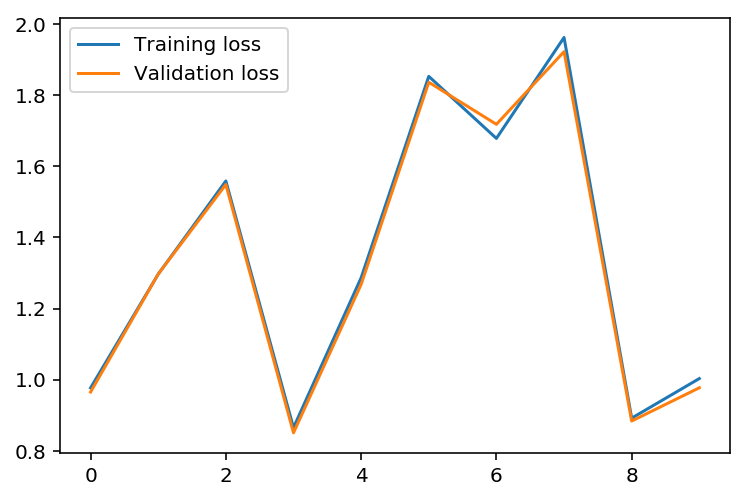

In [191]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

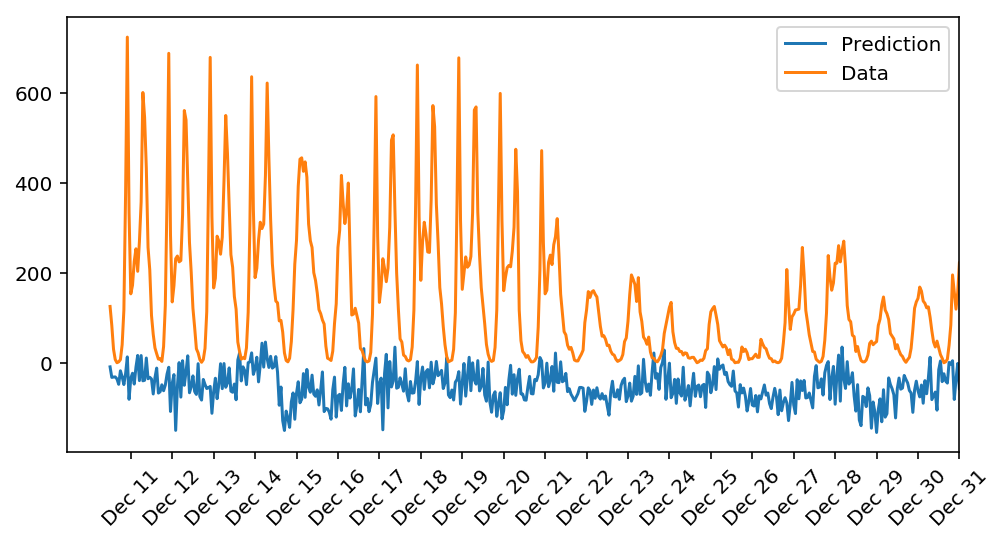

In [192]:
#checking the nn on the test data

fig, ax = plt.subplots(figsize=(8,4))
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)